In [3]:
import random
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
from sklearn.svm import LinearSVC
from collections import defaultdict
from collections import Counter

import time
from google.colab import files
import os

In [ ]:
K = 10 # Vocabulary size
L = 4 # Number of arrows to randomly choose
d = 16 # dim of embedding token
T = 4 # the length of sequence (not include the next token)
token_choice = 'random' # 'random', 'ortho'
ITN = 8000
lr = 0.01
part_1 = 'P1'
part_2 = 'P2'
n = 100

# Related Functions

## Open Training Results

In [ ]:
def after_open_results(df_results_open):

    col_dict_tensor = ['dictionary', 'test_X_12cb', 'test_z_12cb']
    col_dict_array = ['W_svm_12cb', 'W_tau_12cb', 'last_W_12cb']
    col_list = ['correlation_1', 'correlation_2', 'correlation_cb']
    col_dict = ['empir_TPG_12cb', 'training_data', 'SCC_12cb', 'testing_data', 'testing_data_new' 'test_SCC_12cb']
    col_dict_str = ['dictionary']
    col_tensor = ['pseudo_Vocab']
    for col in df_results_open.columns:

        if df_results_open[col].dtype == 'object' and col != 'token_choice':

            for i in df_results_open.index:

                if col in col_dict_tensor:
                    for key, value in df_results_open[col][i].items():
                        if type(value) != torch.tensor:
                            df_results_open[col][i][key] = torch.tensor(df_results_open[col][i][key], dtype=torch.float64)
                if col in col_dict_str:
                    df_results_open.at[i, col] = {int(key): value for key, value in df_results_open.at[i, col].items()}

                if col in col_dict_array:
                    for key, value in df_results_open[col][i].items():
                        if type(value) != np.ndarray:
                            df_results_open[col][i][key] = np.array(df_results_open[col][i][key])

                if col in col_tensor:
                    #for i in df_results_open.index:
                    if type(df_results_open.loc[i, col]) != torch.tensor:
                        df_results_open.at[i, col] = torch.tensor(df_results_open.at[i, col], dtype=torch.float64)
        else:
            df_results_open[col] = df_results_open[col]

    return df_results_open

def after_open_predicts(df_predicts_open):

    col_dict_tensor = ['dictionary', 'test_X_12cb', 'test_z_12cb']
    col_dict_array = ['W_svm_12cb', 'W_tau_12cb', 'last_W_12cb']
    col_dict_str = ['dictionary']
    col_tensor = ['pseudo_Vocab']

    for col in df_predicts_open.columns:

        if df_predicts_open[col].dtype == 'object' and col != 'token_choice':

            # df_predicts_open.at[i, col] = eval(df_predicts_open.at[i, col])
            for i in df_predicts_open.index:
                if col in col_dict_tensor:

                    for key, value in df_predicts_open[col][i].items():
                        if type(value) != torch.tensor:
                            df_predicts_open[col][i][key] = torch.tensor(df_predicts_open[col][i][key], dtype=torch.float64)

                if col in col_dict_str:
                    df_predicts_open.at[i, col] = {int(key): value for key, value in df_predicts_open.at[i, col].items()}

                if col in col_tensor:
                        if type(df_predicts_open[col][i]) != torch.tensor:
                            df_predicts_open.at[i, col] = torch.tensor(df_predicts_open.at[i, col], dtype=torch.float64)

        else:
            df_predicts_open[col] = df_predicts_open[col]

    return df_predicts_open


## Generate Test Data and get X, z

In [ ]:
"""
Get the remaining input tokens based on the priority order of the scc
"""
# Generate weights based on the priority: 0<1<2...
def generate_linear_weights(order):
    n = len(order)
    weights = [i + 1 for i in range(n)]
    total = sum(weights)
    normalized_weights = [w / total for w in weights]  # Normalize to sum to 1
    return normalized_weights

def generate_linear_weights_new(scc_dict):

    total_sccs = len(scc_dict)
    scc_raw_weights = {scc_id: idx + 1 for idx, scc_id in enumerate(sorted(scc_dict.keys()))}

    # Step 1: Compute total raw weight across all tokens
    total_raw_weight = sum(scc_raw_weights[scc_id] * len(tokens) for scc_id, tokens in scc_dict.items())

    # Step 2: Assign normalized weights
    token_weights = {}
    for scc_id, tokens in scc_dict.items():
        group_raw_weight = scc_raw_weights[scc_id] * len(tokens)
        per_token_weight = group_raw_weight / total_raw_weight / len(tokens)
        for token in tokens:
            token_weights[token] = per_token_weight


    return token_weights

def remaining_input_tk(scc, possible_input_tokens):

    # step 1. get the priority order for all possible input tokens
    scc_dict = {} # group ID: token ID -> key:value
    for index, group in enumerate(scc):
        if group not in scc_dict:
            scc_dict[group] = []
        scc_dict[group].append(index)
    scc_dict = {key: [v for v in value if v in possible_input_tokens] for key, value in scc_dict.items() if any(v in possible_input_tokens for v in value)}
    scc_dict = dict(sorted(scc_dict.items()))
    # print("scc_dict(scc_id:token_id):", scc_dict)

    # step 2. generate weight for each token based on the priority of scc_dict.keys(): scc_dict = {0: [1], 1: [0, 4], 6: [7], 7: [8]}
    new_weights = generate_linear_weights_new(scc_dict) #{token_ID: weight}


    # step 3. randomly select one token from the possible_input_tokens based on the weights
    selected_token = np.random.choice(list(new_weights.keys()), p = list(new_weights.values()))

    return selected_token

### Generate data

In [ ]:
def generate_seqs_scc(tpgs, SCCs, T):
    sequence_length = T  # Sequence length is T = 4

    """
    Step 1: Randomly choose the last token k (e_T)
    """
    last_token_k = random.randint(0, K-1)  # Choose a random token as the last one (0 <= k <= K-1)

    tpg_for_k = tpgs[last_token_k]  # Select the TPG for the last token k
    scc_for_k = SCCs[last_token_k]



    """
    Step 2: Randomly choose the next token e_{T+1} in the selected TPG
    """
    ## 2.1 find e_j that have arrows coming from the last token k
    outgoing_edges = [edge for edge in tpg_for_k if edge[0] == last_token_k]
    destination_nodes = [edge[1] for edge in outgoing_edges]
    destination_nodes.append(last_token_k)

    ## 2.2 count the arrows pointing to each destination node (include e_j itself)
    destination_counts = {node: 1 for node in destination_nodes} # start from 1: including e_j itself

    for edge in tpg_for_k:
        if edge[1] in list(destination_counts.keys()):
            destination_counts[edge[1]] += 1

    ## 2.3 randomly choose the next token e_{T+1} based on weighted prob
    total_count = sum(destination_counts.values())
    prob = [count / total_count for count in destination_counts.values()]

    next_token = np.random.choice(list(destination_counts.keys()), p=prob)


    """
    Step 3: Randomly choose the location of the next token in the input sequence
    """
    available_positions = list(range(sequence_length - 1))  # Positions: 0, 1, 2, 3
    next_token_position_input = random.choice(available_positions)  # Choose a position for e_{T+1}

    input_sequence = [None] * (sequence_length - 1) # Initialize the input sequence with None
    input_sequence.append(last_token_k)
    input_sequence[next_token_position_input] = next_token  # Place e_{T+1} in the sequence


    """
    Step 4: Randomly choose the rest of the tokens that have arrows to the next token in the TPG
    """
    remaining_positions = [pos for pos in available_positions if pos != next_token_position_input]

    # Find tokens that have arrows pointing to the chosen next token
    possible_input_tokens = [edge[0] for edge in tpg_for_k if edge[1] == next_token]
    possible_input_tokens.append(next_token) # next_token can also be chosen as the rest of token

    if len(possible_input_tokens) == 0:
        raise ValueError(f"No available nodes in the TPG for token {last_token_k}.")

    # Randomly choose remaining input tokens based on the priority order
    for pos in remaining_positions:

        token = remaining_input_tk(scc_for_k, possible_input_tokens)
        input_sequence[pos] = token

    return input_sequence, next_token

"""
Generate data set with N sequences based on the updated TPG
"""
def generate_data(tpgs, SCCs, n, T):

    results = []
    for i in range(n):
        sequence, next_token = generate_seqs_scc(tpgs,SCCs, T)

        results.append(sequence)

    return results

### Get X and z

In [ ]:
def get_X_new(data, dict_token):

      input_X = []

      for seqs in data:
          values = [dict_token[key].tolist() for key in seqs]  # Get the corresponding values from dict_token
          input_X.append(values)

      input_X = torch.tensor(input_X)
      X = input_X.double() #dtype: torch.float64
      return X

def get_X_z(data, dict_token, toy_case = False, batch_toy = False):

    X = get_X_new(data, dict_token)
    if toy_case and batch_toy:
        input_z = []
        for i in range(len(X)):
            zi = X[i][-1]
            input_z.append(zi)
        input_z = torch.stack(input_z)
        assert input_z.shape == (n, d)
    else:
        input_z = X[:, -1].unsqueeze(1) # [n, d]

    z = input_z.double() #dtype: torch.float64
    return X, z

## Predict the next token for test data
 - Step 1: Predict next token
 - Step 2: check if change topic

In [ ]:
def softmax(x):
    # Subtract the maximum value for numerical stability
    e_x = np.exp(x)
    return e_x / e_x.sum()

In [ ]:
"""
extra 1: check if sequence exists in both Topic 1 and Topic 2 or not (for "Ambiguity")
"""
def get_seqs_topic12(df_results_open, testing_data):

    """
    Get unique tokens for each topic
    """
    unique_tokens_1 = {}
    unique_tokens_2 = {}
    for ei in range(len(df_results_open)):
        data_1 = df_results_open['empir_TPG_12cb'][ei]['data_topic_1']
        data_2 = df_results_open['empir_TPG_12cb'][ei]['data_topic_2']

        unique_tokens_1[ei] = {int(key): set(token for pair in value for token in pair) for key, value in data_1.items()}
        unique_tokens_2[ei] = {int(key): set(token for pair in value for token in pair) for key, value in data_2.items()}

    # Get sequences whose unique tokens exist in both TPG for topic 1 and TPG for topic 2

    seqs_topic12 = {} # save seqs whose unique tokens in both Topic 1 and Topic 2
    seqs_topic12_count = {}
    seqs_topic12_case = {}

    # Get sequences whose unique tokens DON'T exist in both TPG for topic 1 and TPG for topic 2

    N_seqs_topic12 = {} # save seqs whose unique tokens NOT in both Topic 1 and Topic 2
    N_seqs_topic12_count = {}
    N_seqs_topic12_case = {}

    for ei in range (len(df_results_open)):

        seqs_topic12[ei] = {}
        seqs_topic12_count[ei] = 0

        N_seqs_topic12[ei] = {}
        N_seqs_topic12_count[ei] = 0

        test_seqs = df_results_open[testing_data][ei]['test_topic_1']
        for seq_id in range(len(test_seqs)):
            input_seq = test_seqs[seq_id]
            set_seq = set(input_seq)
            last_token = input_seq[-1]

            TPG_1 = unique_tokens_1[ei][last_token]
            TPG_2 = unique_tokens_2[ei][last_token]

            check_results = set_seq.issubset(TPG_1 & TPG_2) # check if unique tokens in the sequence exist in both Topic 1 and Topic 2

            if check_results == True:
                seqs_topic12[ei][seq_id] = test_seqs[seq_id]
                seqs_topic12_count[ei] += 1

            else:
                N_seqs_topic12[ei][seq_id] = test_seqs[seq_id]
                N_seqs_topic12_count[ei] += 1

    print('\n# of seqs in both Topic 1 and Topic 2:', sum(seqs_topic12_count.values()), 'out of', sum(df_results_open['#_seqs_epoch']))
    print('# of seqs in Topic 1 only:', sum(N_seqs_topic12_count.values()), 'out of', sum(df_results_open['#_seqs_epoch']))

    return seqs_topic12, N_seqs_topic12

"""
extra 2: check # of repeated tokens and scc priority (for "Change Topic")
"""
def check_repeated (ei, seq, df_results, hat_y_cb):

    unique_idx_x_i = list(set(seq))
    last_token = seq[-1]
    scc_1 = df_results['SCC_12cb'][ei]['data_topic_1'][last_token]
    idx_scc_1 = {x: scc_1[x] for x in unique_idx_x_i} # match token Id with the scc_ID -> (token_ID: scc_ID)

    scc_cb = df_results['SCC_12cb'][ei]['data_combine'][last_token]
    idx_scc_cb = {x: scc_cb[x] for x in unique_idx_x_i} # match token Id with the scc_ID -> (token_ID: scc_ID)

    highest_scc = max(idx_scc_1.values()) # get the highest scc group ID
    highest_idx = [k for k, v in idx_scc_1.items() if v == highest_scc] # extract token ID with the hightest scc_ID

    dict_counts = dict(Counter(seq))

    result = {'seq': seq, 'hat_y_cb(y:times)': {hat_y_cb: dict_counts[hat_y_cb]}}
    result['highest_idx(idx:times)'] = {idx: dict_counts[idx] for idx in highest_idx}
    result['scc_1(idx:scc_ID)'] = idx_scc_1
    result['scc_cb(idx:scc_ID)'] = idx_scc_cb


    all_greater = all(dict_counts[hat_y_cb] >= dict_counts[token] for token in highest_idx)
    any_greater = any(dict_counts[hat_y_cb] > dict_counts[token] for token in highest_idx)

    if (hat_y_cb in highest_idx) and all_greater:
        case_type = 'case_0'

    else:

        if (hat_y_cb not in highest_idx) and any_greater:
            case_type = 'case_1'
        else:
            case_type = 'case_2'


    result['case_type'] = case_type
    return result

In [ ]:
"""
 ========= Step 1: Predict next token =========
"""
# get the W and W_svm from the training results
def ei_W_Wsvm(ei, df_results):

    # Topic 1: W_svm and W
    W_svm_ei_1 = torch.tensor(df_results['W_svm_12cb'][ei]['data_topic_1'][0])
    W_ei_1 = torch.tensor(df_results['last_W_12cb'][ei]['data_topic_1'])

    # Topic 2: W_svm and W
    W_svm_ei_2 = torch.tensor(df_results['W_svm_12cb'][ei]['data_topic_2'][0])
    W_ei_2 = torch.tensor(df_results['last_W_12cb'][ei]['data_topic_2'])

    # Topic Combine: W_svm and W
    W_svm_ei_cb = torch.tensor(df_results['W_svm_12cb'][ei]['data_combine'][0])
    W_ei_cb = torch.tensor(df_results['last_W_12cb'][ei]['data_combine'])

    return W_svm_ei_1, W_ei_1, W_svm_ei_2, W_ei_2, W_svm_ei_cb, W_ei_cb


def predict_next_token(ei, K, df_results, data, X = 'test_X_12cb', z = 'test_z_12cb'):

    W_svm_ei_1, W_ei_1, W_svm_ei_2, W_ei_2, W_svm_ei_cb, W_ei_cb = ei_W_Wsvm(ei = ei, df_results = df_results)
    pseudo_Vocab = df_results['pseudo_Vocab'][ei]

    needed_W = {
                'last_W_1': W_ei_1,
                'last_W_cb': W_ei_cb
                }

    hat_y = {W: [] for W in needed_W}
    h_prob = {W: [] for W in needed_W}

    for W in needed_W:
        if W == 'last_W_1':
            scc = df_results['SCC_12cb'][ei]['data_topic_1']

        else:
            scc = df_results['SCC_12cb'][ei]['data_combine']

        for i in range(len(df_results['training_data'][ei]['data_topic_1'])):

            seq = df_results[data][ei]['test_topic_1'][i]

            last_token = seq[-1]
            scc_last_token = scc[last_token]
            dict_counts = dict(Counter(seq))

            X_i = df_results[X][ei]['test_topic_1'][i]
            X_i_transpose = X_i.T
            z_i= df_results[z][ei]['test_topic_1'][i]
            z_i_transpose = z_i.T

            XWz = torch.matmul(X_i, torch.matmul(needed_W[W], z_i_transpose))
            softmax_output_i_W = F.softmax(XWz, dim = 0)

            softmax_output_i_W = torch.round(softmax_output_i_W * 1000) / 1000  # round the softmax_output to 3 decimals


            unique_idx = list(set(seq))
            idx_softmax = {val: softmax_output_i_W[seq.index(val)].item() for val in unique_idx} #{idx: softmax_output}

            sf_att_scores = [] # sf_att_scores for idx_i = softmax_output(idx_i) * repeated times of idx_i in X
            for j in range(K):
                if j in dict_counts.keys():
                    sf_att_scores_i = idx_softmax[j] * dict_counts[j]
                else:
                    sf_att_scores_i = 0
                sf_att_scores.append(sf_att_scores_i)
            sf_att_scores = torch.tensor(sf_att_scores).reshape(-1, 1) # shape (K,1)

            max_value = torch.max(sf_att_scores)

            tokens_h_prob = (sf_att_scores == max_value).nonzero(as_tuple=True)
            tokens_h_prob = tokens_h_prob[0].tolist()

            for token_h_prob in tokens_h_prob:

                for key in dict_counts.keys():
                    if dict_counts[key] == dict_counts[token_h_prob] and scc_last_token[token_h_prob] == scc_last_token[key]:
                        if key not in tokens_h_prob:
                            tokens_h_prob.append(key)


            if len(tokens_h_prob) > 1:
                hat_y_i_w_new = random.choice(tokens_h_prob)
            else:
                hat_y_i_w_new = tokens_h_prob[0]

            hat_y[W].append(hat_y_i_w_new) # save the hat_y for each seq with the W
            h_prob[W].append(tokens_h_prob)


    return hat_y, h_prob



In [ ]:
"""
============ Step 2: check if change topic ===========
"""
def check_topic_change(ei, df_results, hat_y, h_prob, data,
                              Weight_1 = 'last_W_1', Weight_cb = 'last_W_cb'):
    print(f"\n========== Current Epoch {ei} ==========")
    seqs_topic12, N_seqs_topic12 = get_seqs_topic12(df_results, data)

    n = len(df_results[data][ei]['test_topic_1'])

    ambiguity = {'#_diff': 0,                 # count # of diff next tokens for each case
                'diff_seqs': {}}          # save the sequences with different next tokens


    change_topic = {'#_diff':0,
                    'diff_seqs': {}}
    change_topic_analysis = {'case_0':{'#_case':0, 'details': {}, 'prob': {}},
                             'case_1':{'#_case':0, 'details': {}, 'prob': {}},
                             'case_2':{'#_case':0, 'details': {}, 'prob': {}}}

    keep_topic = {'#_same': 0,
                  'same_seqs': {}}

    outputs = {'keep_topic': keep_topic, 'ambiguity': ambiguity, 'change_topic': change_topic}


    for i in range(n):

        seq = df_results[data][ei]['test_topic_1'][i]
        unique_idx_x_i = list(set(seq))
        last_token = seq[-1]
        scc_cb = df_results['SCC_12cb'][ei]['data_topic_1'][last_token]
        idx_scc = {x: scc_cb[x] for x in unique_idx_x_i} # match token Id with the scc_ID -> (token_ID: scc_ID)
        highest_scc = max(idx_scc.values()) # get the highest scc group ID
        highest_idx = [k for k, v in idx_scc.items() if v == highest_scc] # extract token ID with the hightest scc_ID

        scc_1 = df_results['SCC_12cb'][ei]['data_topic_1'][last_token]
        scc_12 = df_results['SCC_12cb'][ei]['data_combine'][last_token]
        print(f'\n\nscc_1:', scc_1)
        print(f'scc_cb:', scc_12)

        # ============== 1. keep topic ==============
        if hat_y[Weight_cb][i] in h_prob[Weight_1][i]: # add the highest_idx condition?

            keep_topic['#_same'] +=1
            keep_topic['same_seqs'][i] = (seq, [hat_y[Weight_1][i], hat_y[Weight_cb][i]])
            print('\n============== 1. keep topic ==============')
            print(f'ID {i}:', keep_topic['same_seqs'][i])
            print('highest_prob_W1:', h_prob[Weight_1][i])
            print('highest_prob_Wcb:', h_prob[Weight_cb][i])

        else:
            # ============== 2. ambiguity ==============

            if set(h_prob[Weight_1][i]).issubset(set(h_prob[Weight_cb][i])):

                ambiguity['#_diff'] +=1
                ambiguity['diff_seqs'][i] = (seq, [hat_y[Weight_1][i], hat_y[Weight_cb][i]])
                print('\n============== 2. ambiguity ==============')
                print(f'ID {i}:', ambiguity['diff_seqs'][i])
                print('highest_prob_W1:', h_prob[Weight_1][i])
                print('highest_prob_Wcb:', h_prob[Weight_cb][i])

            # ============== 3. change topic ==============
            else:
                change_topic['#_diff'] +=1
                change_topic['diff_seqs'][i] = (seq, [hat_y[Weight_1][i], hat_y[Weight_cb][i]])
                result = check_repeated (ei = ei, seq = seq, df_results = df_results, hat_y_cb = hat_y[Weight_cb][i])

                if result['case_type'] == "case_1":
                    change_topic_analysis['case_1']['#_case'] +=1
                    change_topic_analysis['case_1']['details'][i] = result
                    change_topic_analysis['case_1']['prob'][i] = {'h_prob_W_1': h_prob[Weight_1][i], 'h_prob_W_cb': h_prob[Weight_cb][i]}

                elif result['case_type'] == "case_2":
                    change_topic_analysis['case_2']['#_case'] +=1
                    change_topic_analysis['case_2']['details'][i] = result
                    change_topic_analysis['case_2']['prob'][i] = {'h_prob_W_1': h_prob[Weight_1][i], 'h_prob_W_cb': h_prob[Weight_1][i]}
                else:
                    change_topic_analysis['case_0']['#_case'] +=1
                    change_topic_analysis['case_0']['details'][i] = result
                    change_topic_analysis['case_0']['prob'][i] = {'h_prob_W_1': h_prob[Weight_1][i], 'h_prob_W_cb': h_prob[Weight_cb][i]}


    if outputs['change_topic']['#_diff'] != 0:
        for case_type in change_topic_analysis.keys():
            print(f'\n----- For {case_type}: -----')
            print('# of differences: ', change_topic_analysis[case_type]['#_case'], "out of", outputs['change_topic']['#_diff'])
            if change_topic_analysis[case_type]['#_case'] != 0:
                for key, value in change_topic_analysis[case_type]['details'].items():
                    print(f'ID {key}:', value)
                    print(f'ID {key}:', change_topic_analysis[case_type]['prob'][key])

    return outputs, change_topic_analysis

"""
Sum the number of differences for each case
"""
def sum_case_results(df_case_results):
    col_not_to_sum = ['current_epoch', 'K', 'L', 'd', 'T', 'token_choice']
    col_to_sum = [col for col in df_case_results.columns if col not in col_not_to_sum]

    sum_row = df_case_results[col_to_sum].sum()
    sum_row = pd.DataFrame([{
        **{col: '' for col in df_case_results.columns if col not in col_to_sum},
        **sum_row.to_dict()
    }], index = ['Total'])

    df_case_results = pd.concat([df_case_results, sum_row])

    return df_case_results

# Bar Plot with Varying Test_T

In [ ]:
train_file_1 = f'file_path/K={K}_L={L}_d={d}_T={T}_{token_choice}_lr={lr}_train_{part_1}.json'
df_results_open_1 = pd.read_json(train_file_1)
df_results_open_1 = after_open_results(df_results_open_1)

train_file_2 = f'file_path/K={K}_L={L}_d={d}_T={T}_{token_choice}_lr={lr}_train_{part_2}.json'
df_results_open_2 = pd.read_json(train_file_2)
df_results_open_2 = after_open_results(df_results_open_2)

"""
Combine two results file
"""
df_results_open_2['current_epoch'] += len(df_results_open_1)
df_results_open = pd.concat([df_results_open_1, df_results_open_2])
df_results_open_T = df_results_open.reset_index(drop=True)
len(df_results_open_T)

## Step 1. Generate the test data and gext X, z

In [ ]:
"""
Section 1 Regenerate Test Data
"""
Test_Ts = [4, 8, 16, 24, 32, 64, 128, 256, 512]


for Test_T in Test_Ts:

    """
    step 1: generate test data based on each Test_T
    """
    if f'new_testing_data_{Test_T}' in df_results_open_T.columns:
        continue

    else:
        new_test_data_lst = []
        for ei in range(len(df_results_open_T)):
            new_test_data = {}
            emp_tpg_1 = df_results_open_T['empir_TPG_12cb'][ei]['data_topic_1']
            emp_tpg_1 = {int(key): value for key, value in emp_tpg_1.items()}
            SCCs_1 = df_results_open_T['SCC_12cb'][ei]['data_topic_1']

            new_test_data_ei = generate_data(emp_tpg_1, SCCs_1, n = n, T = Test_T)
            new_test_data['test_topic_1'] = new_test_data_ei
            new_test_data_lst.append(new_test_data)


        df_results_open_T[f'new_testing_data_{Test_T}'] = new_test_data_lst

    """
    step 2: get X and z of the generated test data
    """
    test_X_12cb_lst = []
    test_z_12cb_lst = []

    for ei in range(len(df_results_open_T)):
        test_X_12cb = {}
        test_z_12cb = {}

        data = df_results_open_T[f'new_testing_data_{Test_T}'][ei]['test_topic_1']
        dict_token = df_results_open_T['dictionary'][ei]

        X, z = get_X_z(data = data, dict_token = dict_token)
        test_X_12cb['test_topic_1'] = X
        test_z_12cb['test_topic_1'] = z

        test_X_12cb_lst.append(test_X_12cb)
        test_z_12cb_lst.append(test_z_12cb)

    if f'test_X_12cb_{Test_T}' in df_results_open_T.columns:
        continue
    else:
        df_results_open_T[f'test_X_12cb_{Test_T}'] = test_X_12cb_lst

    if f'test_z_12cb_{Test_T}' in df_results_open_T.columns:
        continue
    else:
        df_results_open_T[f'test_z_12cb_{Test_T}'] = test_z_12cb_lst


## Step 2. Predict the next token for each T

In [ ]:
"""
Section 2 Predict the next token and check similarity
"""
case_results_new = []

for ei in range(len(df_results_open_T)):

    case_ei = {'current_epoch': ei, 'K': df_results_open_T['K'][ei], 'L': df_results_open_T['L'][ei], 'd': df_results_open_T['d'][ei], 'T': df_results_open_T['T'][ei],
                'token_choice':df_results_open_T['token_choice'][ei], '#_seqs_epoch': n}

    for Test_T in Test_Ts:

        hat_y, h_prob = predict_next_token(ei = ei, K = K, df_results = df_results_open_T, data = f'new_testing_data_{Test_T}', X = f'test_X_12cb_{Test_T}', z = f'test_z_12cb_{Test_T}')

        cases, change_topic_analysis = check_topic_change(ei = ei, df_results = df_results_open_T, hat_y = hat_y, h_prob= h_prob, data = f'new_testing_data_{Test_T}')

        case_ei[f'#_Keep_Topic_{Test_T}'] = cases['keep_topic']['#_same']
        case_ei[f'#_Ambiguity_{Test_T}'] = cases['ambiguity']['#_diff']
        case_ei[f'#_Change_Topic_{Test_T}'] = cases['change_topic']['#_diff']
        case_ei[f'T{Test_T}_case_0'] = change_topic_analysis['case_0']['#_case']
        case_ei[f'T{Test_T}_case_1'] = change_topic_analysis['case_1']['#_case']
        case_ei[f'T{Test_T}_case_2'] = change_topic_analysis['case_2']['#_case']


    case_results_new.append(case_ei)

df_cases_new = pd.DataFrame(case_results_new)
df_cases_new = sum_case_results(df_cases_new)

Streaming output truncated to the last 5000 lines.
scc_1: [0, 1, 2, 3, 5, 4, 6, 7, 8, 9]
scc_cb: [0, 4, 1, 5, 2, 2, 3, 6, 7, 8]

============== 1. keep topic ==============
ID 47: ([4, 5, 4, 2], [4, 4])
highest_prob_W1: [4]
highest_prob_Wcb: [4]


scc_1: [0, 1, 3, 0, 4, 5, 2, 0, 6, 7]
scc_cb: [0, 1, 3, 0, 4, 5, 2, 0, 7, 6]

============== 1. keep topic ==============
ID 48: ([3, 3, 0, 7], [3, 3])
highest_prob_W1: [3]
highest_prob_Wcb: [3]


scc_1: [0, 1, 3, 4, 5, 2, 6, 7, 8, 9]
scc_cb: [2, 3, 4, 1, 5, 0, 6, 7, 8, 9]

============== 1. keep topic ==============
ID 49: ([7, 7, 5, 5], [7, 7])
highest_prob_W1: [7]
highest_prob_Wcb: [7]


scc_1: [0, 1, 3, 0, 4, 5, 2, 0, 6, 7]
scc_cb: [0, 1, 3, 0, 4, 5, 2, 0, 7, 6]

============== 1. keep topic ==============
ID 50: ([0, 7, 7, 7], [7, 7])
highest_prob_W1: [7]
highest_prob_Wcb: [7]


scc_1: [0, 1, 2, 3, 5, 4, 6, 7, 8, 9]
scc_cb: [0, 4, 1, 5, 2, 2, 3, 6, 7, 8]

============== 1. keep topic ==============
ID 51: ([4, 4, 5, 2], [4, 4])
highest_p

In [ ]:
case_test_T = []
for Test_T in Test_Ts:
    case_ei = {'K': df_results_open_T['K'][0], 'L': df_results_open_T['L'][0], 'd': df_results_open_T['d'][0], 'T': df_results_open_T['T'][0], 'token_choice':df_results_open_T['token_choice'][0], '#_total_seq': df_cases_new['#_seqs_epoch']['Total'], 'test_T': Test_T}

    keep_topic = df_cases_new[f'#_Keep_Topic_{Test_T}']['Total']
    ambiguous = df_cases_new[f'#_Ambiguity_{Test_T}']['Total']
    change_topic = df_cases_new[f'#_Change_Topic_{Test_T}']['Total']
    case_ei['#_Keep_Topic'] = keep_topic
    case_ei['#_Ambiguity'] = ambiguous
    case_ei['#_Change_Topic'] = change_topic
    case_ei[f'case_0'] = df_cases_new[f'T{Test_T}_case_0']['Total']
    case_ei[f'case_1'] = df_cases_new[f'T{Test_T}_case_1']['Total']
    case_ei[f'case_2'] = df_cases_new[f'T{Test_T}_case_2']['Total']

    case_test_T.append(case_ei)

df_cases_test_T = pd.DataFrame(case_test_T)
df_cases_test_T.head(10)

## Step 3. Bar plot with varying T

In [ ]:
file_name = f'file_path/varying_T.xlsx'
df_cases_test_T = pd.read_excel(file_name)
df_cases_test_T.head(10)

,Unnamed: 0,K,L,d,T,token_choice,#_total_seq,test_T,#_Keep_Topic,#_Ambiguity,#_Change_Topic,case_0,case_1,case_2
0,0,10,4,16,4,random,5000,4,4930,70,0,0,0,0
1,1,10,4,16,4,random,5000,8,4925,48,27,0,27,0
2,2,10,4,16,4,random,5000,16,4903,27,70,8,62,0
3,3,10,4,16,4,random,5000,24,4924,13,63,3,60,0
4,4,10,4,16,4,random,5000,32,4942,6,52,4,48,0
5,5,10,4,16,4,random,5000,64,4955,2,43,11,22,10
6,6,10,4,16,4,random,5000,128,4982,1,17,0,16,1
7,7,10,4,16,4,random,5000,256,4999,0,1,0,1,0
8,8,10,4,16,4,random,5000,512,5000,0,0,0,0,0


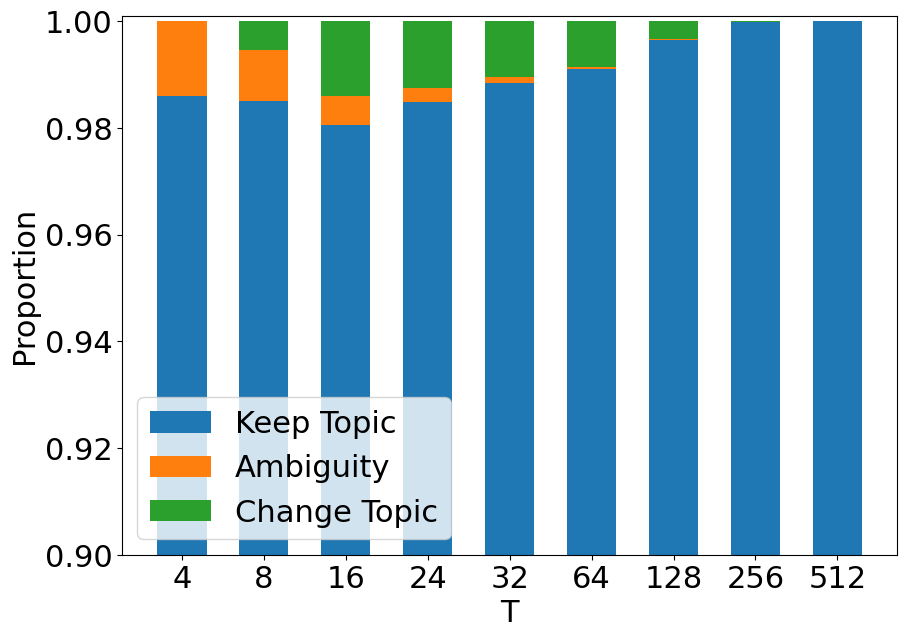

In [6]:
# Extract the data for stacking
keep_topic = (df_cases_test_T['#_Keep_Topic']/df_cases_test_T['#_total_seq'])
ambiguous = (df_cases_test_T['#_Ambiguity']/df_cases_test_T['#_total_seq'])
change_topic = (df_cases_test_T['#_Change_Topic']/df_cases_test_T['#_total_seq'])

# Plotting
plt.figure(figsize=(10, 7))
x = np.arange(len(df_cases_test_T['test_T']))  # Positions for the bars
bar_width = 0.6

plt.bar(x, keep_topic, width=bar_width, label='Keep Topic')
plt.bar(x, ambiguous, width=bar_width, bottom=keep_topic, label='Ambiguity')
plt.bar(x, change_topic, width=bar_width, bottom=keep_topic + ambiguous, label='Change Topic')

# Labels and title

plt.xticks(x, df_cases_test_T['test_T'].tolist(), fontsize = 22)
plt.xlabel("T", fontsize = 22)
plt.ylabel("Proportion", fontsize = 22)
plt.ylim(.90, 1.001)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.legend(fontsize = 22)


plt.show()

# Bar Plot with Varying L

## Step 1. Generate the test data and get X, z

In [ ]:
K = 10 # Vocabulary size
L = 4 # Number of arrows to randomly choose
d = 16 # dim of embedding token
T = 4 # the length of sequence (not include the next token)
token_choice = 'random' # 'random', 'ortho'
ITN = 8000
lr = 0.01
part_1 = 'P1'
part_2 = 'P2'
n = 100

In [ ]:
L_list = [4, 6, 8, 10, 12, 14, 16, 18]
test_T = 20
case_L ={}
for L in L_list:

    """
    extract training data
    """
    train_file_1 = f'file_path/K={K}_L={L}_d={d}_T={T}_{token_choice}_lr={lr}_train_{part_1}.json'
    df_results_open_1 = pd.read_json(train_file_1)
    df_results_open_1 = after_open_results(df_results_open_1)

    train_file_2 = f'file_path/K={K}_L={L}_d={d}_T={T}_{token_choice}_lr={lr}_train_{part_2}.json'
    df_results_open_2 = pd.read_json(train_file_2)
    df_results_open_2 = after_open_results(df_results_open_2)

    # Combine two results file
    df_results_open_2['current_epoch'] += len(df_results_open_1)
    df_results_open = pd.concat([df_results_open_1, df_results_open_2])
    df_results_open_L = df_results_open.reset_index(drop=True)

    """
    step 1: generate test data based on each Test_T
    """
    if f'new_testing_data_L{L}' in df_results_open_L.columns:
        continue

    else:
        new_test_data_lst = []
        for ei in range(len(df_results_open_L)):
            new_test_data = {}
            emp_tpg_1 = df_results_open_L['empir_TPG_12cb'][ei]['data_topic_1']
            emp_tpg_1 = {int(key): value for key, value in emp_tpg_1.items()}
            SCCs_1 = df_results_open_L['SCC_12cb'][ei]['data_topic_1']

            new_test_data_ei = generate_data(emp_tpg_1, SCCs_1, n = n, T = test_T)
            new_test_data['test_topic_1'] = new_test_data_ei
            new_test_data_lst.append(new_test_data)


        df_results_open_L[f'new_testing_data_L{L}'] = new_test_data_lst

    """
    step 2: get X and z of the generated test data
    """
    test_X_12cb_lst = []
    test_z_12cb_lst = []

    for ei in range(len(df_results_open_L)):
        test_X_12cb = {}
        test_z_12cb = {}

        data = df_results_open_L[f'new_testing_data_L{L}'][ei]['test_topic_1']
        dict_token = df_results_open_L['dictionary'][ei]

        X, z = get_X_z(data = data, dict_token = dict_token)
        test_X_12cb['test_topic_1'] = X
        test_z_12cb['test_topic_1'] = z

        test_X_12cb_lst.append(test_X_12cb)
        test_z_12cb_lst.append(test_z_12cb)

    if f'test_X_12cb_L{L}' in df_results_open_L.columns:
        continue
    else:
        df_results_open_L[f'test_X_12cb_L{L}'] = test_X_12cb_lst

    if f'test_z_12cb_L{L}' in df_results_open_L.columns:
        continue
    else:
        df_results_open_L[f'test_z_12cb_L{L}'] = test_z_12cb_lst


    case_L[L] = df_results_open_L


## Step 2. Predict the next token for each L

In [ ]:
case_results_new = []
df_results_open_L = list(case_L.values())[0]

for ei in range(len(df_results_open_L)):

    case_ei = {'current_epoch': ei, 'K': df_results_open_L['K'][ei], 'd': df_results_open_L['d'][ei], 'test_T': test_T, 'token_choice':df_results_open_L['token_choice'][ei], '#_seqs_epoch': n}

    for L in L_list:
        hat_y, h_prob = predict_next_token(ei = ei, K = K, df_results = case_L[L], data = f'new_testing_data_L{L}', X = f'test_X_12cb_L{L}', z = f'test_z_12cb_L{L}')

        cases, change_topic_analysis = check_topic_change(ei = ei, df_results = case_L[L], hat_y = hat_y, h_prob= h_prob, data = f'new_testing_data_L{L}')

        case_ei[f'#_Keep_Topic_L{L}'] = cases['keep_topic']['#_same']
        case_ei[f'#_Ambiguity_L{L}'] = cases['ambiguity']['#_diff']
        case_ei[f'#_Change_Topic_L{L}'] = cases['change_topic']['#_diff']
        case_ei[f'L{L}_case_0'] = change_topic_analysis['case_0']['#_case']
        case_ei[f'L{L}_case_1'] = change_topic_analysis['case_1']['#_case']
        case_ei[f'L{L}_case_2'] = change_topic_analysis['case_2']['#_case']

    case_results_new.append(case_ei)

df_cases_new = pd.DataFrame(case_results_new)
df_cases_new = sum_case_results(df_cases_new)

Streaming output truncated to the last 5000 lines.
# of differences:  0 out of 2

----- For case_1: -----
# of differences:  2 out of 2
ID 2: {'seq': [6, 4, 4, 1, 6, 1, 6, 4, 6, 4, 1, 4, 6, 1, 4, 1, 1, 1, 4, 4], 'hat_y_cb(y:times)': {4: 8}, 'highest_idx(idx:times)': {1: 7}, 'scc_1(idx:scc_ID)': {1: 3, 4: 2, 6: 2}, 'scc_cb(idx:scc_ID)': {1: 2, 4: 1, 6: 1}, 'case_type': 'case_1'}
ID 2: {'h_prob_W_1': [1], 'h_prob_W_cb': [4]}
ID 64: {'seq': [3, 5, 3, 5, 5, 4, 4, 3, 4, 5, 5, 4, 4, 4, 5, 5, 4, 3, 3, 5], 'hat_y_cb(y:times)': {5: 8}, 'highest_idx(idx:times)': {4: 7}, 'scc_1(idx:scc_ID)': {3: 3, 4: 4, 5: 1}, 'scc_cb(idx:scc_ID)': {3: 1, 4: 4, 5: 2}, 'case_type': 'case_1'}
ID 64: {'h_prob_W_1': [4], 'h_prob_W_cb': [5]}

----- For case_2: -----
# of differences:  0 out of 2

========== Current Epoch 0 ==========

# of seqs in both Topic 1 and Topic 2: 3240 out of 5000
# of seqs in Topic 1 only: 1760 out of 5000

========== Current Epoch 0 ==========

# of seqs in both Topic 1 and Topic 2: 3191 o

In [ ]:
df_cases_test_L = pd.DataFrame()

case_test_L = []
for L in L_list:
    case_ei = {'K': df_cases_new['K'][0], 'L': L, 'd': df_cases_new['d'][0], 'test_T': test_T, 'token_choice':df_cases_new['token_choice'][0], '#_total_seq': df_cases_new['#_seqs_epoch']['Total']}

    keep_topic = df_cases_new[f'#_Keep_Topic_L{L}']['Total']
    ambiguous = df_cases_new[f'#_Ambiguity_L{L}']['Total']
    change_topic = df_cases_new[f'#_Change_Topic_L{L}']['Total']
    case_ei['#_Keep_Topic'] = keep_topic
    case_ei['#_Ambiguity'] = ambiguous
    case_ei['#_Change_Topic'] = change_topic
    case_ei[f'case_0'] = df_cases_new[f'L{L}_case_0']['Total']
    case_ei[f'case_1'] = df_cases_new[f'L{L}_case_1']['Total']
    case_ei[f'case_2'] = df_cases_new[f'L{L}_case_2']['Total']


    case_test_L.append(case_ei)

df_cases_test_L = pd.DataFrame(case_test_L)
df_cases_test_L

,K,L,d,test_T,token_choice,#_total_seq,#_Keep_Topic,#_Ambiguity,#_Change_Topic,case_0,case_1,case_2
0,10,4,16,20,random,5000,4911,13,76,13,63,0
1,10,6,16,20,random,5000,4915,25,60,8,52,0
2,10,8,16,20,random,5000,4909,34,57,11,46,0
3,10,10,16,20,random,5000,4921,38,41,6,35,0
4,10,12,16,20,random,5000,4907,41,52,15,37,0
5,10,14,16,20,random,5000,4898,62,40,9,31,0
6,10,16,16,20,random,5000,4914,49,37,9,28,0
7,10,18,16,20,random,5000,4901,63,36,5,31,0


In [ ]:
file_name = f'file_path/varying_L.xlsx'
df_cases_test_L = pd.DataFrame()
df_cases_test_L = pd.read_excel(file_name)
df_cases_test_L

,Unnamed: 0,K,L,d,test_T,token_choice,#_total_seq,#_Keep_Topic,#_Ambiguity,#_Change_Topic,case_0,case_1,case_2
0,0,10,4,16,20,random,5000,4911,13,76,13,63,0
1,1,10,6,16,20,random,5000,4915,25,60,8,52,0
2,2,10,8,16,20,random,5000,4909,34,57,11,46,0
3,3,10,10,16,20,random,5000,4921,38,41,6,35,0
4,4,10,12,16,20,random,5000,4907,41,52,15,37,0
5,5,10,14,16,20,random,5000,4898,62,40,9,31,0
6,6,10,16,16,20,random,5000,4914,49,37,9,28,0
7,7,10,18,16,20,random,5000,4901,63,36,5,31,0


## Step 3. Bar plot with varying L

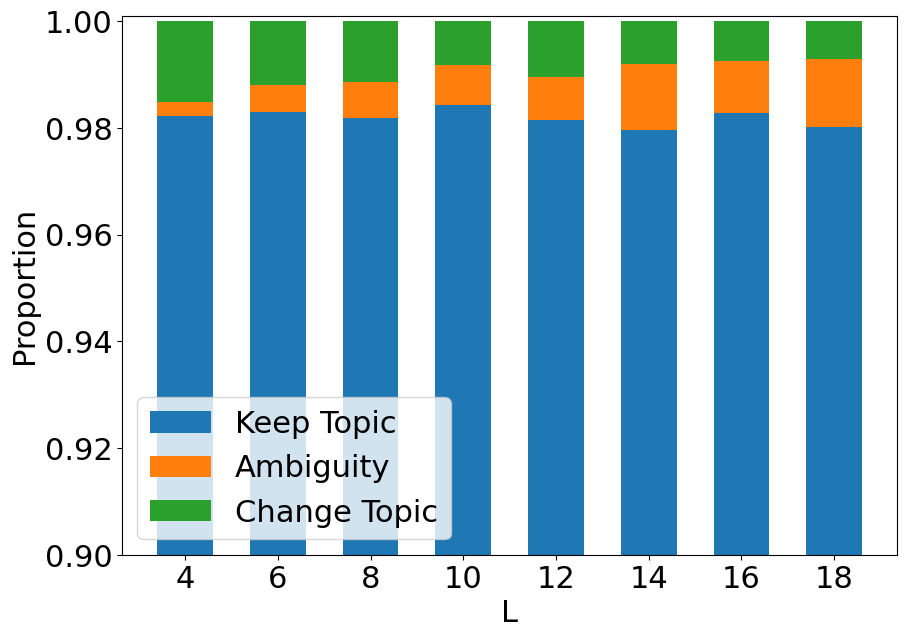

In [ ]:
# Extract the data for stacking
keep_topic = (df_cases_test_L['#_Keep_Topic']/df_cases_test_L['#_total_seq'])
ambiguous = (df_cases_test_L['#_Ambiguity']/df_cases_test_L['#_total_seq'])
change_topic = (df_cases_test_L['#_Change_Topic']/df_cases_test_L['#_total_seq'])

# Plotting
plt.figure(figsize=(10, 7))
x = np.arange(len(df_cases_test_L['L']))  # Positions for the bars
bar_width = 0.6

plt.bar(x, keep_topic, width=bar_width, label='Keep Topic')
plt.bar(x, ambiguous, width=bar_width, bottom=keep_topic, label='Ambiguity')
plt.bar(x, change_topic, width=bar_width, bottom=keep_topic + ambiguous, label='Change Topic')

# Labels and title

plt.xticks(x, df_cases_test_L['L'].tolist(), fontsize = 22)
plt.xlabel("L", fontsize = 22)
plt.ylabel("Proportion", fontsize = 22)
plt.ylim(0.90, 1.001)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.legend(fontsize = 22)


plt.show()